In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

In [3]:
import pandas as pd
def getData(filename):
    chunksize = 1200000
    flag =1
    for data in pd.read_csv(filename, sep=",", chunksize=chunksize):
        while flag<2 and chunksize < 1200000:
            print(data)
        flag+=1
    print(data.head())
    print(list(data.columns.values))
    print(type(data))
    
    return data

In [4]:
import random
filename = '../shot_listed_dataset/CoverTypeNewNormalized.csv'
dataset=getData(filename).values.tolist()
random.shuffle(dataset)
dataset=pd.DataFrame(dataset) #from dataset_list to dataset_dataframe after suffling
# print(dataset)

   Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0   0.850622  0.105556  0.150943                          0.045351   
1   0.879149  0.163889  0.188679                          0.426304   
2   0.767116  0.327778  0.320755                          0.068027   
3   0.791494  0.338889  0.226415                          0.294785   
4   0.867220  0.575000  0.584906                          0.385488   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                       -0.003509                         0.631060   
1                        0.189474                         0.177358   
2                        0.038596                         0.259652   
3                       -0.077193                         0.085486   
4                        0.314035                         0.074020   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.866142        0.874016          0.548   
1       0.897638        0.866142          0.500   
2    

In [5]:
X=dataset.iloc[:,0:-1]
y=dataset.iloc[:,-1]

In [6]:
def split_data(data):
    # splitting the data
    
    msk = np.random.rand(len(data)) < 0.9
    yy = [54] #test title is 54 after suffleing the dataframe 
    train = data[msk]
    test = data[~msk]
    x_train = train[train.columns[:train.shape[1] - 1]]  # all columns except the last are x variables
    y_train = train[yy[0]].tolist()  # the last column as y variable
    x_test = test[test.columns[:test.shape[1] - 1]]
    y_test = test[yy[0]].tolist()  # the last column as y variable
    y_train = [0 if i == 7 else i for i in y_train]  # replace label 7 with 0
    y_test = [0 if i == 7 else i for i in y_test]  # replace label 7 with 0
    return x_train, y_train, x_test, y_test

In [7]:
X_train, y_train, X_test, y_test = split_data(dataset)

# call the Encoder pkl file

In [8]:
import pickle

# Load the encoder model from the saved file
with open("Encoder.pkl", "rb") as file: #"rb"= read mode
    encoder = pickle.load(file)

encoder


In [15]:
encoded_X = pd.DataFrame(encoder.predict(X))
encoded_X = encoded_X.add_prefix('feature_')

encoded_X_train = pd.DataFrame(encoder.predict(X_train))
encoded_X_train = encoded_X_train.add_prefix('feature_')

encoded_X_test = pd.DataFrame(encoder.predict(X_test))
encoded_X_test = encoded_X_test.add_prefix('feature_')



60/60 [==============================] - 0s 1ms/step


# tune D tree for Ada-Boost

In [19]:
from sklearn.tree import DecisionTreeClassifier
params_dt = {'max_depth': 12,    
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)

model_dt.fit(encoded_X_train, y_train)

DecisionTreeClassifier(max_depth=12, max_features='sqrt')

In [20]:
# Finding mean absolute error
preds = model_dt.predict(encoded_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.7040762308099524

In [27]:
# Defining the best parameter with optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
K = 5 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned_dt = np.array(encoded_X)
target_train_tunned_dt = np.array(y)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds_dt = np.zeros((len(train_tunned_dt)))
abs_error_arr_dt=[]
def objective(trial):

 for train_index, val_index in (skf.split(encoded_X,y)):
    train_X, valid_X = train_tunned_dt[train_index], train_tunned_dt[val_index]
    train_Y, valid_Y = target_train_tunned_dt[train_index], target_train_tunned_dt[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
        'criterion':trial.suggest_categorical('criterion',["gini", "entropy", "log_loss"]), #The function to measure the quality of a split.
        'splitter':trial.suggest_categorical('splitter',["best", "random"]),
        'max_features':trial.suggest_categorical('max_features',['sqrt','log2',1,2,3,4,5,6,7,8,9,10,11]), #a categorical value can be an integer
        'random_state':trial.suggest_int('random_state',0,5),


        }
    model = DecisionTreeClassifier(**param)  
        
    model.fit(train_X,train_Y)
        
    preds = model.predict(valid_X)
    oof_preds_dt[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
#  print(len(oof_preds_dt))
      
 mae = mean_absolute_error(target_train_tunned_dt, oof_preds_dt)
        
 return mae

In [28]:
# this is the main optuna for optimizing a object-->"objective"
import optuna
study = optuna.create_study(direction='minimize')

[I 2024-02-06 21:32:21,907] A new study created in memory with name: no-name-45ffc862-5703-4361-b79e-1ded6fdd4622


In [29]:

study.optimize(objective, n_trials=100) # 150 bar "objective" object ke trial kore kore dekhbe, here total 5*100=750
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-06 21:32:25,203] Trial 0 finished with value: 0.7099173123927401 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_features': 'sqrt', 'random_state': 4}. Best is trial 0 with value: 0.7099173123927401.
[I 2024-02-06 21:32:25,736] Trial 1 finished with value: 0.7072650683862916 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_features': 6, 'random_state': 5}. Best is trial 1 with value: 0.7072650683862916.
[I 2024-02-06 21:32:25,836] Trial 2 finished with value: 0.7676426231213271 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_features': 3, 'random_state': 0}. Best is trial 1 with value: 0.7072650683862916.
[I 2024-02-06 21:32:25,974] Trial 3 finished with value: 0.7145457382079151 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_features': 8, 'random_state': 0}. Best is trial 1 with value: 0.7072650683862916.
[I 2024-02-06 21:32:26,136] Trial 4 finished with value: 0.7365957668105466 and parameters: {'criterion

Number of finished trials: 100
Best trial: {'criterion': 'log_loss', 'splitter': 'random', 'max_features': 11, 'random_state': 5}


In [39]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.6894794321077539
  Params: 
    criterion: log_loss
    splitter: random
    max_features: 11
    random_state: 5


In [33]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study, params=["criterion", "splitter","max_features","random_state"])
fig_study.show()
plt.savefig('E:/4-2/Thesis/Thesis_Report/Encoder/Ada-Boost/D-tree_tune.png')

<Figure size 640x480 with 0 Axes>

# tune Ada-Boost

In [34]:
# train the model with random parameter
from sklearn.ensemble import AdaBoostClassifier
# Preparing the regressor and fitting data with some parameters
dt_params = study.best_trial.params
model_dt = DecisionTreeClassifier(**dt_params)
#model_dt = estimator
#model = predictor = model_dt.fit()

model_Ada = AdaBoostClassifier(
        estimator=model_dt,
        n_estimators=180, # maximum number of estimators at which boosting is terminated
        learning_rate=1.2,
        algorithm="SAMME", #SAMME.R=real boosting algorithm
        
     )

model_Ada.fit(encoded_X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(criterion='log_loss',
                                                    max_features=11,
                                                    random_state=5,
                                                    splitter='random'),
                   learning_rate=1.2, n_estimators=180)

In [35]:
# Finding mean absolute error
preds = model_Ada.predict(encoded_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.5606140815246162

In [36]:
# Defining the best parameter with optuna

K = 5 # 5 fold cross validation
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned_Ada= np.array(encoded_X)
target_train_tunned_Ada = np.array(y)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds_Ada = np.zeros((len(train_tunned_Ada)))
abs_error_arr_Ada=[]
def objective_Ada(trial):

 for train_index, val_index in (skf.split(encoded_X,y)):
    train_X, valid_X = train_tunned_Ada[train_index], train_tunned_Ada[val_index]
    train_Y, valid_Y = target_train_tunned_Ada[train_index], target_train_tunned_Ada[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process 
        'estimator':model_dt,
        'n_estimators':trial.suggest_int("n_estimators",50,500), # maximum number of estimators at which boosting is terminated
        'learning_rate':trial.suggest_float("learning_rate",1,3),
        'algorithm':trial.suggest_categorical("algorithm",["SAMME","SAMME.R"]),
        'random_state':trial.suggest_int('random_state',0,5),
        }
    model_2 = AdaBoostClassifier(**param)  
        
    model_2.fit(train_X,train_Y)
        
    preds = model_2.predict(valid_X)
    oof_preds_Ada[val_index] = preds # preds gives total 3846 predicted value for valid_X

#  abs_error=np.abs(oof_preds-target_train_tunned).mean() 
#  abs_error_arr.append(abs_error)  
#  abs_error=np.abs(oof_preds-target_train).mean()
 
#  print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned_Ada, oof_preds_Ada)
        
 return mae

In [37]:
# this is the main optuna for optimizing a object-->"objective"
study_Ada = optuna.create_study(direction='minimize',study_name="Ada_tunning")

[I 2024-02-06 22:26:43,237] A new study created in memory with name: Ada_tunning


In [38]:

study_Ada.optimize(objective_Ada, n_trials=100) # 150 bar "objective" object ke trial kore kore dekhbe, here total 5*100=750
print('Number of finished trials:', len(study_Ada.trials))
print('Best trial:', study_Ada.best_trial.params)

[I 2024-02-06 22:26:51,851] Trial 0 finished with value: 0.7138696760101929 and parameters: {'n_estimators': 289, 'learning_rate': 1.6065877212887292, 'algorithm': 'SAMME', 'random_state': 0}. Best is trial 0 with value: 0.7138696760101929.
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to ci

Number of finished trials: 100
Best trial: {'n_estimators': 106, 'learning_rate': 1.4357863007839493, 'algorithm': 'SAMME.R', 'random_state': 3}


In [42]:
#evaluate the trial
print("Number of finished trials: ", len(study_Ada.trials))
print("Best trial:")
trial = study_Ada.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.7075770970929326
  Params: 
    n_estimators: 106
    learning_rate: 1.4357863007839493
    algorithm: SAMME.R
    random_state: 3


In [44]:
from matplotlib import pyplot as plt
fig_study_Ada = optuna.visualization.plot_parallel_coordinate(study_Ada, params=["n_estimators", "learning_rate","algorithm","random_state"])
fig_study_Ada.show()

# process the whole data

In [46]:
filename_2 = '../shot_listed_dataset/Cover_type_whole_genuine_dataset_normalization.csv'
dataset_2=getData(filename_2).values.tolist()
random.shuffle(dataset_2)

dataset_2=pd.DataFrame(dataset_2) #from dataset_list to dataset_dataframe after suffling
print(dataset_2)

   Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0   0.672888  0.141667  0.045455                          0.184681   
1   0.671332  0.155556  0.030303                          0.151754   
2   0.726801  0.386111  0.136364                          0.191840   
3   0.721877  0.430556  0.272727                          0.173228   
4   0.672628  0.125000  0.030303                          0.109520   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                        0.000000                         0.071659   
1                       -0.009983                         0.054798   
2                        0.108153                         0.446817   
3                        0.196339                         0.434172   
4                       -0.001664                         0.054939   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.870079        0.913386       0.582677   
1       0.866142        0.925197       0.594488   
2    

In [47]:
X_2=dataset_2.iloc[:,0:-1]
y_2=dataset_2.iloc[:,-1]
X_train_2, y_train_2, X_test_2, y_test_2 = split_data(dataset_2)

In [48]:
encoded_X_2 = pd.DataFrame(encoder.predict(X_2))
encoded_X_2 = encoded_X_2.add_prefix('feature_')

encoded_X_train_2 = pd.DataFrame(encoder.predict(X_train_2))
encoded_X_train_2 = encoded_X_train_2.add_prefix('feature_')

encoded_X_test_2 = pd.DataFrame(encoder.predict(X_test_2))
encoded_X_test_2 = encoded_X_test_2.add_prefix('feature_')



1811/1811 [==============================] - 2s 1ms/step


# fit the Ada-Boost model

In [49]:

K = 5 # 5 fold cross validation
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)

In [50]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train_Ada = np.array(encoded_X_train_2)
target_train_Ada = np.array(y_train_2)

test_Ada = np.array(encoded_X_test_2) # or test_Ada = np.array(X)


test_preds_Ada = np.zeros((len(test_Ada)))
oof_preds_Ada = np.zeros((len(train_Ada)))

for train_index, val_index in tqdm(skf.split(encoded_X_train_2,y_train_2), total=5):
    train_X, valid_X = train_Ada[train_index], train_Ada[val_index]
    train_y, valid_y = target_train_Ada[train_index], target_train_Ada[val_index]
    ada_params = study_Ada.best_trial.params
    model_Ada_2 = AdaBoostClassifier(**ada_params,estimator=model_dt)
    model_Ada_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_Ada_2.predict(valid_X)
    oof_preds_Ada[val_index] = preds
    # for test accuracy
    preds = model_Ada_2.predict(test_Ada)
    test_preds_Ada += (preds)/5
print(np.abs(oof_preds_Ada-target_train_Ada).mean())

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

 20%|██        | 1/5 [00:03<00:12,  3.14s/it]c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

 40%|████      | 2/5 [00:06<00:09,  3.07s/it]c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

 60%|██████    | 3/5 [00:08<00:05,  2.94s/it]c:\Users\USER\AppData\Local\Programs\Python\P

0.21124151418810544


In [52]:
from sklearn.metrics import accuracy_score
# valid_Acc_SVC=accuracy_score(target_train,oof_preds)
# print(valid_Acc_SVC)
target_test=np.array(y_test_2)
# another technique for calculate test accuracy
test_Acc_Ada=accuracy_score(target_test,test_preds_Ada.round())
print(test_Acc_Ada)

0.8584571832979476


In [53]:
#validation accuracy
valid_Acc=accuracy_score(target_train_Ada,oof_preds_Ada)
print(valid_Acc)

0.8539742562786883


In [54]:
# train accuracy
train_Acc=model_Ada_2.score(encoded_X_train_2,y_train_2)
print(train_Acc)

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but AdaBoostClassifier was fitted without feature names



0.9707998218242369


In [55]:
# test_accuracy
test_Acc=model_Ada_2.score(encoded_X_test_2,y_test_2)
print(test_Acc)

0.8558679854314467


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but AdaBoostClassifier was fitted without feature names



# Evaluation

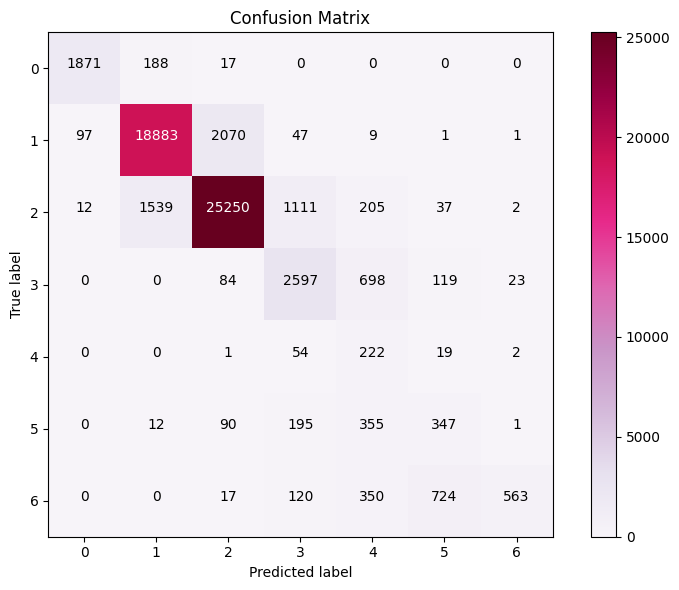

In [57]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test_2, test_preds_Ada.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()


# Another process

In [58]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train_Ada = np.array(encoded_X_train)
target_train_Ada = np.array(y_train)

test_Ada = np.array(encoded_X_test) # or test_Ada = np.array(X)


test_preds_Ada = np.zeros((len(test_Ada)))
oof_preds_Ada = np.zeros((len(train_Ada)))

for train_index, val_index in tqdm(skf.split(encoded_X_train,y_train), total=5):
    train_X, valid_X = train_Ada[train_index], train_Ada[val_index]
    train_y, valid_y = target_train_Ada[train_index], target_train_Ada[val_index]
    ada_params = study_Ada.best_trial.params
    model_Ada_2 = AdaBoostClassifier(**ada_params,estimator=model_dt)
    model_Ada_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_Ada_2.predict(valid_X)
    oof_preds_Ada[val_index] = preds
    # for test accuracy
    preds = model_Ada_2.predict(test_Ada)
    test_preds_Ada += (preds)/5
print(np.abs(oof_preds_Ada-target_train_Ada).mean())

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

 40%|████      | 2/5 [00:00<00:00, 11.77it/s]c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The S

0.6043829296424452


In [59]:
# train accuracy
train_Acc=model_Ada_2.score(encoded_X_train,y_train)
print(train_Acc)

# test_accuracy
test_Acc=model_Ada_2.score(encoded_X_test,y_test)
print(test_Acc)

0.9422145328719723
0.7384859714134463


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but AdaBoostClassifier was fitted without feature names

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but AdaBoostClassifier was fitted without feature names

